# Análise de dados - Curva característica do diodo e do painel solar

In [278]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.optimize import curve_fit, fmin
from scipy.constants import e, k

import exp_physics as ep

In [227]:
#plt.rcParams['figure.figsize'] = (10, 8)
#plt.rcParams['figure.facecolor'] = 'white'
sns.set_theme()

## Diodo

In [228]:
df_diodo = pd.read_csv('./Dados/diodo.csv')

In [229]:
R = 330.2, 0.1	# Resistência e incerteza

In [230]:
popt, pcov = curve_fit(
	lambda x, H, A, b: H + A * np.exp(b * x),
	xdata=np.arange(0, 200),
	ydata=df_diodo['Tensao A'][0:200],
	p0=[ 0, 0.00015, 0.01 ]
)

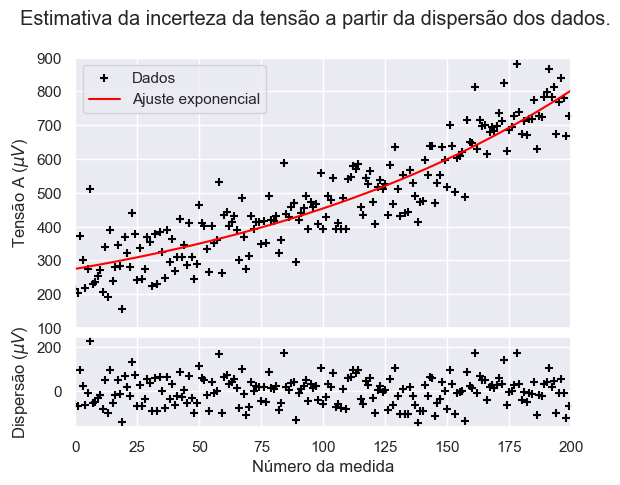

In [231]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'height_ratios': (3,1), 'hspace': 0.05 })
plt.suptitle('Estimativa da incerteza da tensão a partir da dispersão dos dados.')

axs[0].scatter(np.arange(0, 200), df_diodo['Tensao A'][0:200] * 1E6, label='Dados', marker='+', color='black')

x = np.linspace(0, 200, 1000)
axs[0].plot(x, (popt[0]+popt[1]*np.exp(popt[2]*x))*1E6, color='red', label='Ajuste exponencial')

axs[0].set_ylim(100, 900)
axs[0].set_ylabel('Tensão A ($\mu V$)')
axs[0].legend()

axs[1].scatter( np.arange(0, 200), (df_diodo['Tensao A'][0:200] - popt[0]-popt[1]*np.exp(popt[2]*np.arange(0, 200)))*1E6, marker='+', color='black')

axs[1].set_ylabel('Dispersão ($\mu V$)')
axs[1].set_xlabel('Número da medida')
axs[1].set_xlim(0, 200)

plt.savefig('Plots/diode_dipersion.png', dpi=300, bbox_inches='tight')
plt.show()

In [232]:
sigma = df_diodo['Tensao A'][0:200] - popt[0] - popt[1] * np.exp(popt[2]*np.arange(0, 200))

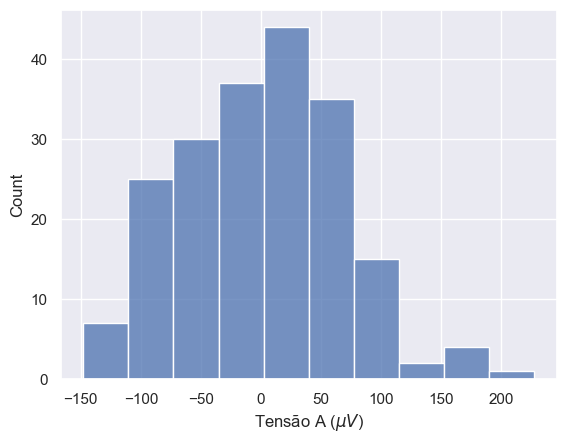

In [233]:
sns.histplot(sigma*1E6, bins=10)
plt.xlabel('Tensão A ($\mu V$)')
plt.show()

In [234]:
df_diodo['sTensao A']	= df_diodo['Tensao A'] * 0 + sigma.std()
df_diodo['sTensao B']	= df_diodo['Tensao A'] * 0 + sigma.std()

#df_diodo['Corrente']	= df_diodo['Tensao A'] / R[0]
df_diodo['sCorrente']	= np.sqrt(( df_diodo['sTensao A'] / R[0] )**2 + ( df_diodo['Tensao A'] * R[1] / R[0]**2 )**2)

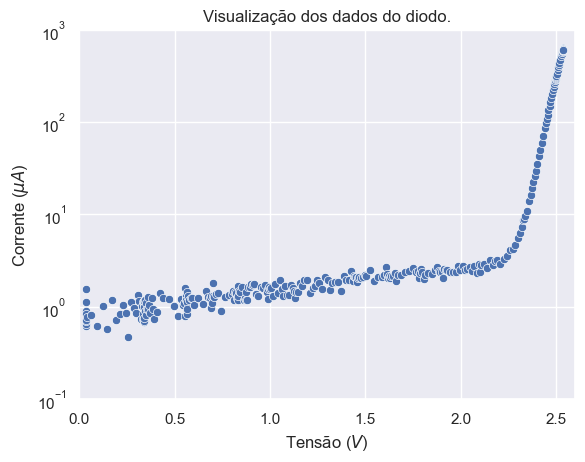

In [235]:
plt.title('Visualização dos dados do diodo.')
sns.scatterplot(x=df_diodo['Tensao B'], y=df_diodo['Corrente']*1E6)
plt.yscale('log')
plt.xlim(0, 2.6)
plt.ylim(1E-1, 1E3)
plt.xlabel('Tensão ($V$)')
plt.ylabel('Corrente ($\mu A$)')
plt.savefig('Plots/diode_visual.png', dpi=300, bbox_inches='tight')
plt.show()

In [236]:
df_fit = df_diodo.loc[(df_diodo['Tensao B'] > 2.3) & (df_diodo['Tensao B'] < 2.5)]

In [237]:
popt, pcov = curve_fit(
	lambda x, H, I, b: H + I * (np.exp(b*x) - 1),
	xdata=df_fit['Tensao B'],
	ydata=df_fit['Corrente'],
	sigma=df_fit['sCorrente'],
	p0=[ 3E-6, 6.290535404538017e-27, 20.96174081],
	maxfev=10000
)

In [238]:
popt

array([-7.81346382e-07,  1.52290794e-27,  2.14726168e+01])

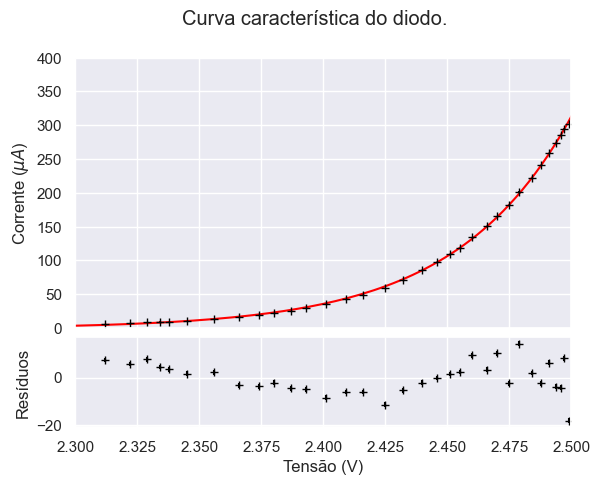

In [239]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'height_ratios': (3,1), 'hspace': 0.05 })
plt.suptitle('Curva característica do diodo.')

axs[0].errorbar(
	x=df_fit['Tensao B'],
	y=df_fit['Corrente'] * 1E6,
	xerr=df_fit['sTensao B'],
	yerr=df_fit['sCorrente'] * 1E6,
	fmt=' ', marker='+', color='black'
)

x = np.linspace(0, 2.6, 1000)
sns.lineplot(x=x, y=(popt[0]+popt[1]*(np.exp(popt[2]*x)-1))*1E6, color='red', ax=axs[0])

axs[1].errorbar(
	x=df_fit['Tensao B'],
	y=( df_fit['Corrente'] - popt[0] - popt[1] * ( np.exp(popt[2]*df_fit['Tensao B']) - 1 ) ) / df_fit['sCorrente'],
	xerr=df_fit['sTensao B'],
	yerr=1,
	fmt=' ', marker='+', color='black'
)

axs[0].set_ylabel('Corrente ($\mu A$)')
axs[0].set_xlim(2.3, 2.5)
axs[0].set_ylim(0, 400)

axs[1].set_ylabel('Resíduos')
axs[1].set_xlabel('Tensão (V)')

plt.savefig('Plots/diode_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [240]:
e / (k * popt[2]) - 273

267.43334569973103

In [241]:
np.sum( ( df_fit['Corrente'] - popt[0] - popt[1] * ( np.exp(popt[2]*df_fit['Tensao B']) - 1 ) )**2 / (df_fit['sCorrente'])**2 ) / df_fit.shape[0]

44.20516362393653

## Painel Solar

### Análise Inicial

In [242]:
df_painel = pd.read_csv('./Dados/painel_solar.csv')

df_painel.drop('Tempo',axis=1,inplace=True)

df_painel.rename(columns={"Tensao B": "Tensão",
                          "Tensao A": "Tensão (Corrente)"},
                           inplace=True)

df_painel.drop_duplicates(keep='last',
                          inplace=True)

df_painel.reset_index(drop=True, inplace=True)

In [243]:
df_painel

,Tensão (Corrente),Tensão,Corrente
0,0.015,6.274,0.00
1,0.015,6.273,0.00
2,0.015,6.272,0.00
3,0.015,6.271,0.00
4,0.015,6.270,0.00
...,...,...,...
404,0.076,0.144,0.02
405,0.075,0.144,0.02
406,0.075,0.143,0.02
407,0.075,0.142,0.02


In [244]:
R = 4.7, 0.05

In [245]:
df_painel['Corrente'] = df_painel['Tensão (Corrente)'] / R[0]
df_painel['sTensão'] = pd.Series(np.ones(len(df_painel['Tensão'])) * 67.9*10**(-6))
df_painel['sCorrente']	= np.sqrt(( df_painel['sTensão'] / R[0] )**2 +
                                  ( df_painel['Tensão (Corrente)'] * R[1] / R[0]**2 )**2)

In [246]:
df_painel

,Tensão (Corrente),Tensão,Corrente,sTensão,sCorrente
0,0.015,6.274,0.003191,0.000068,0.000037
1,0.015,6.273,0.003191,0.000068,0.000037
2,0.015,6.272,0.003191,0.000068,0.000037
3,0.015,6.271,0.003191,0.000068,0.000037
4,0.015,6.270,0.003191,0.000068,0.000037
...,...,...,...,...,...
404,0.076,0.144,0.016170,0.000068,0.000173
405,0.075,0.144,0.015957,0.000068,0.000170
406,0.075,0.143,0.015957,0.000068,0.000170
407,0.075,0.142,0.015957,0.000068,0.000170


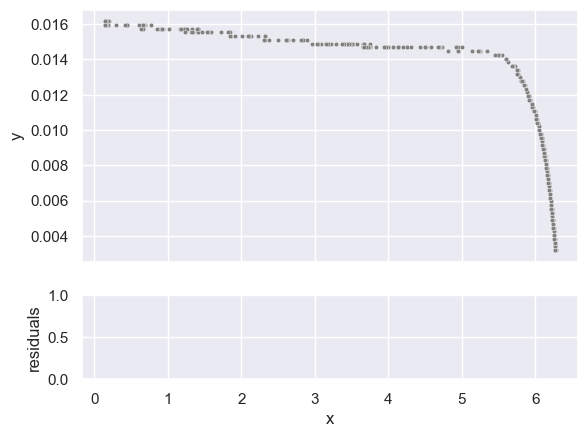

In [247]:
ep.residual_plot(x=df_painel['Tensão'], y=df_painel['Corrente'])
plt.show()

In [248]:
T = 300
b_approx = e/(100*k*T)

fitfunc = lambda V, iL, i0, b: iL - i0*(np.exp(b*V)-1)

In [249]:
fit, cov = curve_fit(fitfunc,
                    df_painel['Tensão'],
                    df_painel['Corrente'],
                    p0=[0.016, 0.001, b_approx],
                    maxfev=1000)

In [176]:
fit

array([1.52144321e-02, 1.11709107e-12, 3.68012414e+00])

In [250]:
np.sqrt(abs(cov))

array([[2.66178077e-05, 1.85937897e-09, 6.96899677e-04],
       [1.85937897e-09, 3.08066094e-13, 1.16722969e-07],
       [6.96899677e-04, 1.16722969e-07, 4.42299906e-02]])

In [251]:
4.42299906*(e/((fit[2]**2) * k*T))*10**(-2)

0.12632746043380763

In [223]:
38.68/3.68012414

10.510515006703008

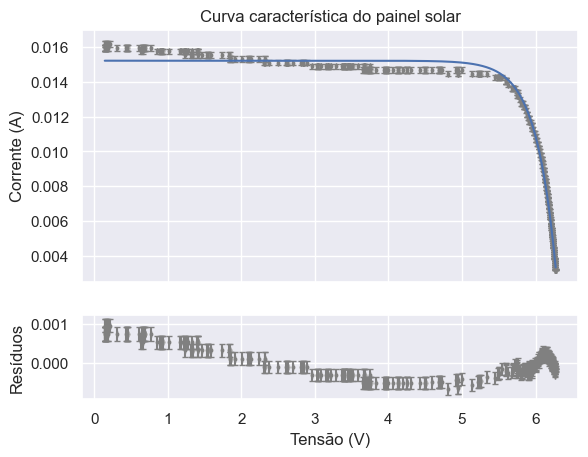

In [180]:
ep.residual_plot(x= df_painel['Tensão'],
                y= df_painel['Corrente'],
                func = fitfunc,
                params= fit,
                x_title='Tensão (V)',
                y_title='Corrente (A)',
                residual_title='Resíduos',
                title='Curva característica do painel solar',
                x_sigma=df_painel['sTensão'],
                y_sigma=df_painel['sCorrente'],
)

In [194]:
dof = len(df_painel['Tensão'])-3
dof

406

In [195]:
ep.chisquare(vals=df_painel['Corrente'],
            exp=fitfunc(df_painel['Tensão'],*fit),
            sigma=df_painel['sCorrente'],
            dof=dof
)

7.369260109202862

In [196]:
ep.chisquare(vals=df_painel['Corrente'],
            exp=fitfunc(df_painel['Tensão'],*fit),
            sigma=df_painel['sCorrente'],
)

2991.9196043363618

#### Potência

In [186]:
fitfunc_pot = lambda V, iL, i0, b: fitfunc(V, iL, i0, b)*V

In [187]:
fit_pot, cov_pot = curve_fit(fitfunc_pot, df_painel['Tensão'], df_painel['Tensão']*df_painel['Corrente'], p0=fit, maxfev=1000)

In [252]:
fit_pot

array([1.47674753e-02, 1.20512796e-13, 4.03048399e+00])

In [193]:
np.sqrt(abs(cov_pot))

array([[1.72380025e-05, 4.15180198e-10, 4.74012711e-04],
       [4.15180198e-10, 1.52846124e-14, 1.75743752e-08],
       [4.74012711e-04, 1.75743752e-08, 2.02093670e-02]])

In [283]:
fmin(lambda x: -fitfunc_pot(x, *fit_pot),-0.07)

Optimization terminated successfully.
         Current function value: -0.078491
         Iterations: 26
         Function evaluations: 52


array([5.55264063])

In [286]:
0.0785/5.552641

0.01413741677158671

In [266]:
ep.chisquare(vals=df_painel['Corrente']*df_painel['Tensão'],
            exp=fitfunc_pot(df_painel['Tensão'],*fit_pot),
            sigma=np.sqrt(df_painel['Corrente']**2 *df_painel['sCorrente']**2 +  df_painel['Tensão']**2 * df_painel['sTensão']**2),
            dof=dof
)

47.13402668565716

In [265]:
ep.chisquare(vals=df_painel['Corrente']*df_painel['Tensão'],
            exp=fitfunc_pot(df_painel['Tensão'],*fit_pot),
            sigma=np.sqrt(df_painel['Corrente']**2 *df_painel['sCorrente']**2 +  df_painel['Tensão']**2 * df_painel['sTensão']**2),
)

19136.41483437681

In [267]:
potencia = np.sqrt(df_painel['Corrente']**2 *df_painel['sCorrente']**2 +  df_painel['Tensão']**2 * df_painel['sTensão']**2)

In [268]:
potencia.mean()

0.0003060369083664549

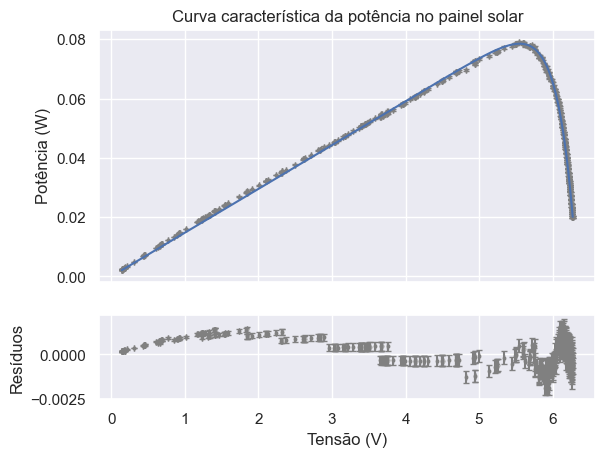

In [264]:
ep.residual_plot(x= df_painel['Tensão'],
                y= df_painel['Corrente']*df_painel['Tensão'],
                func = fitfunc_pot,
                params= fit_pot,
                x_title='Tensão (V)',
                y_title='Potência (W)',
                residual_title='Resíduos',
                title='Curva característica da potência no painel solar',
                x_sigma=df_painel['sTensão'],
                y_sigma=np.sqrt(df_painel['Corrente']**2 *df_painel['sCorrente']**2 +  df_painel['Tensão']**2 * df_painel['sTensão']**2)
)

Text(0.5, 0.98, 'Visualização dos dados do painel solar')

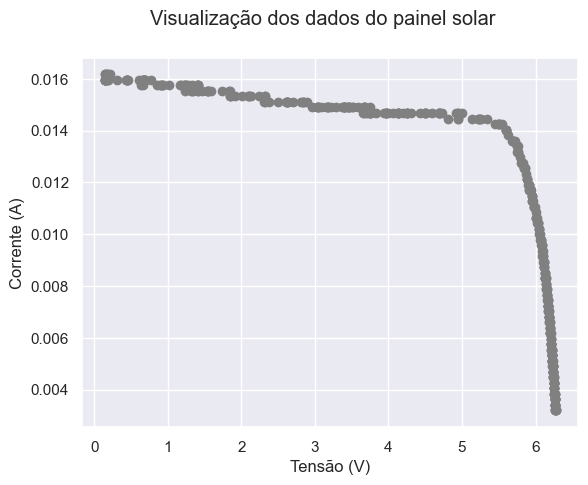

In [192]:
plt.scatter(df_painel['Tensão'], df_painel['Corrente'],color='gray')
plt.xlabel('Tensão (V)')
plt.ylabel('Corrente (A)')
plt.suptitle('Visualização dos dados do painel solar')